# Upgrading CMA-ME to CMA-MAE on the Sphere Benchmark

_This tutorial is part of the series of pyribs tutorials! See [here](https://docs.pyribs.org/en/latest/tutorials.html) for the list of all tutorials and the order in which they should be read._

In the [previous tutorial](https://docs.pyribs.org/en/latest/tutorials/lunar_lander.html), we showed how to implement the CMA-ME algorithm in pyribs to tackle the lunar lander problem. CMA-ME enabled us to search for a diverse collection of high-performing lunar lander agents, including ones which landed like a space shuttle:

In [1]:
from IPython.display import display, HTML
display(HTML("""<video width="360" height="auto" controls><source src="https://raw.githubusercontent.com/icaros-usc/pyribs/master/docs/_static/imgs/lunar-lander-left.mp4" type="video/mp4" /></video>"""))

Recent work introduced [Covariance Matrix Adaptation MAP-Annealing (CMA-MAE)](https://arxiv.org/abs/2205.10752), an algorithm which builds on and improves CMA-ME. CMA-MAE not only has strong theoretical guarantees, it also empirically outperforms CMA-ME in a variety of domains.

One such domain is the sphere linear projection benchmark introduced in [Fontaine 2020](https://arxiv.org/abs/1912.02400). The below heatmaps compare CMA-MAE and CMA-ME on the 100-dimensional version of this benchmark. We can clearly see that CMA-MAE does a better job of populating the archive with high-performing solutions than CMA-ME.

In [2]:
display(HTML("""<video width="720" height="auto" autoplay muted playsinline loop><source src="https://raw.githubusercontent.com/icaros-usc/pyribs/master/docs/_static/imgs/cma-mae-vs-cma-me-imp.mp4" type="video/mp4" /></video>"""))

In this tutorial, we'll show you how to implement this more advanced algorithm in pyribs. To understand how CMA-MAE operates, we'll compare it to CMA-ME on the benchmark mentioned above, and we'll run multiple versions of it to see how different hyperparameters affect its performance.

## Setup

First, let's install pyribs.

In [ ]:
%pip install ribs[visualize]

In [3]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

## The Sphere Linear Projection Benchmark

Next, let's define the sphere function that we'll be using as we introduce CMA-MAE. This benchmark, introduced in [Fontaine 2020](https://arxiv.org/abs/1912.02400), challenges a QD algorithm's ability to handle distortions in the measure space.

The objective function is the negative [sphere function](https://en.wikipedia.org/wiki/Test_functions_for_optimization):

$$f(\mathbb{\theta}) = -\sum_{i=1}^n \theta_i^2$$

where $n$ is the dimensionality chosen for the sphere function (in this tutorial, we use 100 dimensions). In this benchmark, the function is further modified such that the center is shifted to $[0.4 * 5.12, 0.4 * 5.12, ...]$, so that the optimal solution is not the zero vector. Furthermore, the outputs of the function are normalized to the range $[0, 100]$.

Meanwhile, the measure function is a linear projection, i.e., a weighted sum of the components of the input vector. Given a clip function defined as follows:

$$clip(\theta_i) = \begin{cases} \theta_i & \text{if} -5.12 \le \theta_i \le 5.12 \\ 5.12/\theta_i & \text{otherwise} \end{cases}$$

The measure function outputs two values:

$$m(\theta) = \left( \sum_{i=1}^{\lfloor\frac{n}{2}\rfloor}clip(\theta_i), \sum_{i=\lfloor\frac{n}{2}\rfloor+1}^n clip(\theta_i) \right)$$

In short, this measure function creates distortion in the measure space that prevents a QD algorithm from easily reaching the bounds of the archive. To better understand this benchmark and its properties, refer to Appendix B of [Fontaine 2022](https://arxiv.org/abs/2205.10752).

In [4]:
def sphere(solution_batch):
    """Sphere function evaluation and measures for a batch of solutions.

    Args:
        solution_batch (np.ndarray): (batch_size, dim) batch of solutions.
    Returns:
        objective_batch (np.ndarray): (batch_size,) batch of objectives.
        measures_batch (np.ndarray): (batch_size, 2) batch of measures.
    """
    dim = solution_batch.shape[1]

    # Shift the Sphere function so that the optimal value is at x_i = 2.048.
    sphere_shift = 5.12 * 0.4

    # Normalize the objective to the range [0, 100] where 100 is optimal.
    best_obj = 0.0
    worst_obj = (-5.12 - sphere_shift)**2 * dim
    raw_obj = np.sum(np.square(solution_batch - sphere_shift), axis=1)
    objective_batch = (raw_obj - worst_obj) / (best_obj - worst_obj) * 100

    # Calculate measures.
    clipped = solution_batch.copy()
    clip_mask = (clipped < -5.12) | (clipped > 5.12)
    clipped[clip_mask] = 5.12 / clipped[clip_mask]
    measures_batch = np.concatenate(
        (
            np.sum(clipped[:, :dim // 2], axis=1, keepdims=True),
            np.sum(clipped[:, dim // 2:], axis=1, keepdims=True),
        ),
        axis=1,
    )

    return objective_batch, measures_batch

## Introducing CMA-MAE

When inserting solutions into an archive, CMA-ME quickly moves away from high-objective solutions. This happens because after discovering a solution with a high objective value, subsequent solutions found in the same cell (and more generally, in the same region) have a low improvement value.

The intuition of CMA-MAE is that there could be value in discovering more solutions in a high-objective region. For instance, there could be even better solutions in the same region, but CMA-ME will move away from the region regardless if it does not discover a better solution in the next few iterations.

CMA-MAE overcomes this problem by using a threshold value (not the objective value) to determine whether a new solution is accepted by the archive. Formally, a new solution $\theta'$ in cell $e$ is accepted to the archive if and only if $f(\theta') > t_e$, where $t_e$ is the threshold of cell $e$, and $f(\theta')$ is the objective value of $\theta'$. The "improvement value" of a solution is calculated as $\Delta = f(\theta') - t_e$. When a cell does not have a solution, its threshold $t_e$ is initialized to a predefined minimum threshold $min_f$.

Furthermore, after $\theta'$ is accepted into cell $e$, $t_e$ is updated according to the equation $t_e \gets (1 - \alpha) t_e + \alpha f(\theta')$ where the constant $\alpha$ denotes the _archive learning rate_ and controls how quickly the threshold is adapted.

When $\alpha = 1$, **CMA-MAE behaves like CMA-ME**, with the improvement values $\Delta$ quickly dropping to zero. Meanwhile, if $\alpha = 0$, **CMA-MAE behaves like CMA-ES**, as the improvement values always correspond to the objective values since the threshold never changes, resulting in CMA-MAE only optimizing the objective.

To understand how using a threshold can be useful, consider this example from [Fontaine 2022](https://arxiv.org/abs/2205.10752):

> Consider discovering solutions in the same cell with objective value 100 in 5 consecutive iterations. The improvement values computed by CMA-ME would be 100, 0, 0, 0, 0, thus CMA-ME would move rapidly away from this cell. The improvement values computed by CMA-MAE with α = 0.5 would diminish smoothly as follows: 100, 50, 25, 12.5, 6.25, enabling further exploitation of the high-performing region.

## CMA-MAE with pyribs

Setting up CMA-MAE in pyribs is similar to CMA-ME. However, there are a few key differences, which we will review below.

### GridArchive

First, we will create the [`GridArchive`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html). The archive is 100x100 and stores 100-dimensional solutions. The ranges of the archive are determined by the maximum outputs of the measure function. Since the $clip(\theta_i)$ function has a maximum output of 5.12, and each component of the output is the sum of $\frac{n}{2}$ clipped components, the bounds of the measure space are $\pm 5.12 * \frac{n}{2}$.

Next, the key difference from CMA-ME is that this archive takes in the `learning_rate` parameter ($\alpha$) which controls how quickly the threshold in each cell is updated. We set this to 0.01 from the CMA-MAE paper. The second difference is that this archive takes in a  `threshold_min` parameter ($min_f$) which is the starting threshold for each cell. This threshold is typically the minimum objective in the problem, hence we choose 0.0.

**Note: threshold_min**
> If your solutions $\theta$ consistently have objective values $f(\theta) = min_f$, you may need to set $min_f$ to be slightly smaller so that these solutions are accepted into the archive. This is because solutions are accepted if and only if $f(\theta) > t_e$. Thus, if $f(\theta) = t_e$, then $\theta$ will not be accepted.

In [5]:
from ribs.archives import GridArchive

max_bound = 100 / 2 * 5.12

archive = GridArchive(solution_dim=100,
                      dims=(100, 100),
                      ranges=[(-max_bound, max_bound), (-max_bound, max_bound)],
                      learning_rate=0.01,
                      threshold_min=0.0)

In CMA-MAE, since solutions are added to the archive based on the **threshold** of each cell rather than on the **objective** of the elite in each cell, it is possible for CMA-MAE to make "backwards" progress. _Specifically, a solution's objective can exceed the cell's threshold value but not exceed the objective of the cell's current elite,_ which results in overwriting the **better** solution.

For this reason, CMA-MAE sometimes benefits from a separate **result archive** that keeps track of the best solutions encountered in each cell. The `GridArchive` does this by default since it has a default `learning_rate=1.0` and `threshold_min=-inf`. Hence, we create an archive below which is identical to the one above except for the `learning_rate` and `threshold_min`.

In [6]:
result_archive = GridArchive(solution_dim=100,
                             dims=(100, 100),
                             ranges=[(-max_bound, max_bound), (-max_bound, max_bound)])

### EvolutionStrategyEmitter

Next, we set up 15 instances of the [`EvolutionStrategyEmitter`](https://docs.pyribs.org/en/latest/api/ribs.emitters.EvolutionStrategyEmitter.html). The key difference from CMA-ME's `EvolutionStrategyEmitter` is that these emitters use _improvement ranking_ rather than _two-stage improvement ranking_. Two-stage improvement ranking (see the [Lunar Lander tutorial](https://docs.pyribs.org/en/latest/tutorials/lunar_lander.html)) considers the "status" and "value" of each solution, such that solutions which introduced new cells in the archive come first, followed by solutions which improved existing cells and solutions which were not added. In contrast, improvement ranking considers only the improvement values $\Delta = f(\theta') - t_e$, i.e., the difference between the objective values of incumbent solutions and the threshold of their corresponding cells in the archive.

There are further differences which set these emitters apart from the ones which are used in CMA-ME. First, the CMA-MAE emitters below use the "mu" `selection_rule`, which affects which solutions the emitter uses as parents for updating CMA-ES. The default "filter" selection (used in CMA-ME) uses all solutions which added a new cell or improved the archive, while "mu" selects the top half of all the generated solutions as parents. Second, the CMA-MAE emitters use a "basic" restart rule, which restarts the emitter according to the convergence rules of CMA-ES. The default "no_improvement" restart rule restarts the emitter when none of its generated solutions are inserted into the archive.

In [7]:
from ribs.emitters import EvolutionStrategyEmitter

emitters = [
    EvolutionStrategyEmitter(
        archive,
        x0=np.zeros(100),
        sigma0=0.5,
        ranker="imp",
        selection_rule="mu",
        restart_rule="basic",
        batch_size=36,
    ) for _ in range(15)
]

### Scheduler

Finally, the [`Scheduler`](https://docs.pyribs.org/en/latest/api/ribs.schedulers.Scheduler.html) controls how the emitters interact with the archive and result archive. On every iteration, the scheduler calls the emitters to generate solutions. After the user evaluates these generated solutions, the scheduler inserts the solutions into both the archive and result archive. It then passes feedback from the archive (but not the result archive) to the emitters. In this manner, the emitters only interact with the archive, but the result archive stores all the best solutions found by CMA-MAE.

In [8]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters, result_archive=result_archive)

### Summary: Differences Between CMA-ME and CMA-MAE

To summarize, the differences between CMA-ME and CMA-MAE in pyribs are as follows:

* The archive (we used `GridArchive` but you can also use another archive) takes in a `learning_rate` and `threshold_min` parameter. The `learning_rate` is between 0 and 1 (inclusive), and the `threshold_min` typically corresponds to the minimum objective of the problem.
* A second result archive is created to store best solutions, as introducing thresholds means that the first archive is not guaranteed to store the best solutions. This archive is identical to the first, but it does not have `learning_rate` or `threshold_min` parameters.
* `EvolutionStrategyEmitter` uses improvement ranking (`ranker="imp"`) rather than two-stage improvement ranking (`ranker="2imp"`).
* `EvolutionStrategyEmitter` uses `selection_rule="mu"` and `restart_rule="basic"` instead of the default `selection_rule="filter"` and `restart_rule="no_improvement"`.
* `Scheduler` also takes in the `result_archive`.

Note that some of these differences are flexible; in particular, you can try playing around with the `selection_rule` and `restart_rule` to see how these parameters affect the behavior of CMA-MAE.

## Aside: Activating CMA-ME Behavior

When creating the latest version of pyribs, we wondered whether we should explicitly support CMA-ME since CMA-MAE is theoretically equivalent to CMA-ME at $\alpha=1.0$. Ultimately, we decided to continue supporting CMA-ME behavior for two reasons.

First, let us consider how the improvement is computed in each algorithm. In CMA-ME, improvement is computed in two stages: (1) the solution's status (i.e., whether it was new, improved an existing cell in the archive, or was not inserted at all), and (2) a value which depends on the status. In contrast, CMA-MAE computes a single improvement value $\Delta$ which is calculated in the same manner regardless of the solution's status. While CMA-MAE is theoretically equivalent to CMA-ME when $\alpha=1$, this difference in improvement value computation may lead to slight differences between CMA-MAE and CMA-ME.

Second, CMA-MAE always requires defining `threshold_min`, and in some problems, this value is not known beforehand. While it is possible to set `threshold_min` to an arbitrarily low value, we foresee that users may wish to only use CMA-ME without having to worry about `threshold_min`.

Thus, we have made it possible to activate the original CMA-ME behavior by passing in $\alpha=1$ and $min_f=-\infty$ (note that these are in fact the default values for all archives). The table below shows all the possible values of `learning_rate` and `threshold_min` for the archives.

| `learning_rate` ($\alpha$) | `threshold_min` ($min_f$) | Improvement values          |
| -------------------------- | ------------------------- | --------------------------- |
| $1$                        | $-\infty$                 | Two-stage (CMA-ME)          |
| $0\le\alpha\le1$           | (any value)               | $f(\theta) - t_e$ (CMA-MAE) |

Supporting this behavior introduces two additional considerations:

1. When we perform batch addition via the `add()` method on an archive with CMA-MAE, we apply the CMA-MAE batch addition rule in Appendix H of [Fontaine 2022](https://arxiv.org/abs/2205.10752). However, when using CMA-ME settings, we update the threshold by taking the maximum objective value to maintain consistency with the original algorithm.
2. When using the CMA-ME settings, using a regular `ImprovementRanker` (i.e. `ranker="imp"`) is not advisable, as CMA-ME is only designed to work with two-stage improvement ranking (it is okay to use non-two stage versions of [other rankers](https://docs.pyribs.org/en/latest/api/ribs.emitters.rankers.html), however).

## Running CMA-MAE

Having set up the necessary components above, we now run CMA-MAE for 10,000 iterations in accordance with the experiments in [Fontaine 2022](https://arxiv.org/abs/2205.10752). Note that we report the **normalized QD score** here, which is the QD score divided by the number of cells in the archive. This experiment should take **~5 minutes** to run.

In [9]:
total_itrs = 10_000

for itr in trange(1, total_itrs + 1, file=sys.stdout, desc='Iterations'):
    solution_batch = scheduler.ask()
    objective_batch, measure_batch = sphere(solution_batch)
    scheduler.tell(objective_batch, measure_batch)

    # Output progress every 500 iterations or on the final iteration.
    if itr % 500 == 0 or itr == total_itrs:
        tqdm.write(f"Iteration {itr:5d} | "
                   f"Archive Coverage: {result_archive.stats.coverage * 100:6.3f}%  "
                   f"Normalized QD Score: {result_archive.stats.norm_qd_score:6.3f}")

Iteration   500 | Archive Coverage: 57.910%  Normalized QD Score: 46.191                                                                                    
Iteration  1000 | Archive Coverage: 66.210%  Normalized QD Score: 51.180                                                                                    
Iteration  1500 | Archive Coverage: 72.000%  Normalized QD Score: 54.795                                                                                    
Iteration  2000 | Archive Coverage: 75.200%  Normalized QD Score: 56.734                                                                                    
Iteration  2500 | Archive Coverage: 76.500%  Normalized QD Score: 58.192                                                                                    
Iteration  3000 | Archive Coverage: 78.030%  Normalized QD Score: 59.573                                                                                    
Iteration  3500 | Archive Coverage: 78.240%  Normalized QD

## Visualization

Now we visualize the result archive with [`grid_archive_heatmap`](https://docs.pyribs.org/en/latest/api/ribs.visualize.grid_archive_heatmap.html) from the [`ribs.visualize`](https://docs.pyribs.org/en/latest/api/ribs.visualize.html) module (as mentioned previously, the archive used in the main algorithm does not always hold the best solutions, while the result archive does).

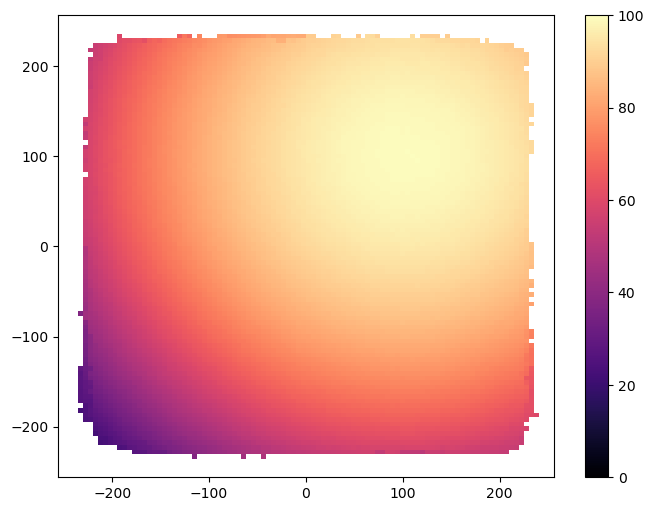

In [10]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(result_archive, vmin=0, vmax=100)

## Exploring the Effect of Learning Rate $\alpha$

In the previous section, we explored CMA-MAE using $\alpha = 0.01$, but what about other settings of $\alpha$? In theory, lower values of $\alpha$ should result in a greater emphasis on optimization, to the point that CMA-MAE becomes CMA-ES at $\alpha = 0.0$. Meanwhile, higher values should result in less emphasis on optimization, to the point that CMA-MAE becomes CMA-ME at $\alpha = 1.0$. We'll see if we can reproduce this behavior in our experiments by exploring how different learning rates affect CMA-MAE on the sphere function. We first define a method for creating a scheduler with a given `learning_rate`.

In [11]:
def create_scheduler(learning_rate):
    max_bound = 100 / 2 * 5.12

    archive = GridArchive(solution_dim=100,
                          dims=(100, 100),
                          ranges=[(-max_bound, max_bound), (-max_bound, max_bound)],
                          learning_rate=learning_rate,
                          threshold_min=0)

    result_archive = GridArchive(solution_dim=100,
                                 dims=(100, 100),
                                 ranges=[(-max_bound, max_bound), (-max_bound, max_bound)])

    emitters = [
      EvolutionStrategyEmitter(
          archive,
          x0=np.zeros(100),
          sigma0=0.5,
          ranker="imp",
          selection_rule="mu",
          restart_rule="basic",
          batch_size=36,
      ) for _ in range(15)
    ]

    return Scheduler(archive, emitters, result_archive=result_archive)

Then, we run the experiments with a range of learning rates while keeping track of the performance (normalized QD score and archive coverage) for each learning rate. This experiment should take **~15 minutes** to complete. To save time, we reduce the iterations for this experiment from 10,000 to 5,000.

In [12]:
# The learning rates that we run CMA-MAE with.
learning_rates = [0, 0.001, 0.01, 0.1, 1]

# Run for 5000 iterations.
total_itrs = 5000

# All schedulers for the experiments.
all_schedulers = [
    create_scheduler(lr) for lr in learning_rates
]

# Tracks the metrics of all the experiments.
all_metrics = {}

for li, (scheduler, learning_rate) in enumerate(zip(all_schedulers, learning_rates)):    
    result_archive = scheduler.result_archive

    # Metrics that we track.
    metrics = {
        "Archive Coverage": {
            "x": [0],
            "y": [0.0],
        },
        "Normalized QD Score": {
            "x": [0],
            "y": [0.0],
        },
    }

    print(f"=== ({li+1}/{len(learning_rates)}) Running CMA-MAE with learning_rate = {learning_rate} ===")
    for itr in trange(1, total_itrs + 1, file=sys.stdout, desc='Iterations'):
        solution_batch = scheduler.ask()
        objective_batch, measure_batch = sphere(solution_batch)
        scheduler.tell(objective_batch, measure_batch)

        if itr % 500 == 0 or itr == total_itrs:
            tqdm.write(f"Iteration {itr:5d} | "
                       f"Archive Coverage: {result_archive.stats.coverage * 100:6.3f}%  "
                       f"Normalized QD Score: {result_archive.stats.norm_qd_score:6.3f}")

            metrics["Archive Coverage"]["x"].append(itr)
            metrics["Archive Coverage"]["y"].append(result_archive.stats.coverage * 100)
            metrics["Normalized QD Score"]["x"].append(itr)
            metrics["Normalized QD Score"]["y"].append(result_archive.stats.norm_qd_score)

        all_metrics[learning_rate] = metrics

=== (1/5) Running CMA-MAE with learning_rate = 0 ===
Iteration   500 | Archive Coverage:  3.220%  Normalized QD Score:  3.111                                                                                    
Iteration  1000 | Archive Coverage:  3.520%  Normalized QD Score:  3.406                                                                                    
Iteration  1500 | Archive Coverage:  3.890%  Normalized QD Score:  3.760                                                                                    
Iteration  2000 | Archive Coverage:  4.230%  Normalized QD Score:  4.086                                                                                    
Iteration  2500 | Archive Coverage:  4.270%  Normalized QD Score:  4.125                                                                                    
Iteration  3000 | Archive Coverage:  4.380%  Normalized QD Score:  4.230                                                                                    
Itera

Now, we can plot the metrics for each learning rate.

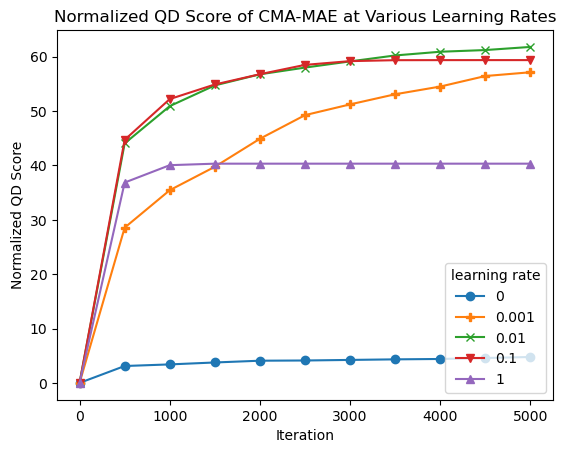

In [13]:
# Markers for accessiblity.
markers=['o', 'P', 'x', 'v', '^']

for learning_rate, marker in zip(learning_rates, markers):
    metrics = all_metrics[learning_rate]
    plt.plot(metrics["Normalized QD Score"]["x"],
             metrics["Normalized QD Score"]["y"],
             marker=marker)

plt.title("Normalized QD Score of CMA-MAE at Various Learning Rates")
plt.xlabel("Iteration")
plt.ylabel("Normalized QD Score")
plt.legend(learning_rates, title="learning rate");

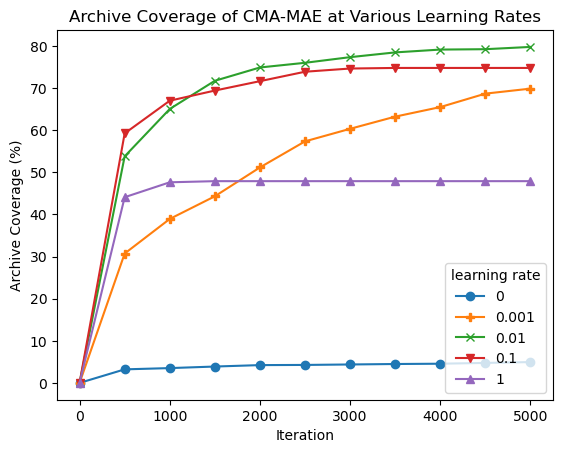

In [14]:
for learning_rate, marker in zip(learning_rates, markers):
    metrics = all_metrics[learning_rate]
    plt.plot(metrics["Archive Coverage"]["x"],
             metrics["Archive Coverage"]["y"],
             marker=marker)

plt.title("Archive Coverage of CMA-MAE at Various Learning Rates")
plt.xlabel("Iteration")
plt.ylabel("Archive Coverage (%)")
plt.legend(learning_rates, title="learning rate");

From the plots, we observe the following:

- At one extreme, with learning rate 0, CMA-MAE makes no progress in exploring the archive since it focuses solely on optimizing the objective. This leads it to have the lowest QD score.
- On the other extreme, with learning rate 1, CMA-MAE stops making progress after around 500 iterations. Recall that this method is equivalent to CMA-ME; while it does explore the archive, it does not achieve the theoretical "density descent" property from the CMA-MAE paper, which holds for any $\alpha$ strictly between 0 and 1. This property yields better exploration capabilities in CMA-MAE.
- With intermediate learning rates, particularly 0.01 and 0.1, the algorithm makes quick progress, surpassing the performance of all other learning rate settings. Learning rate 0.001 seems to progress very slowly as it may spend too much time in high-objective regions before moving away, but it may catch up with the other learning rates given enough iterations.

Let's also plot heatmaps of each algorithm to further understand their performance.

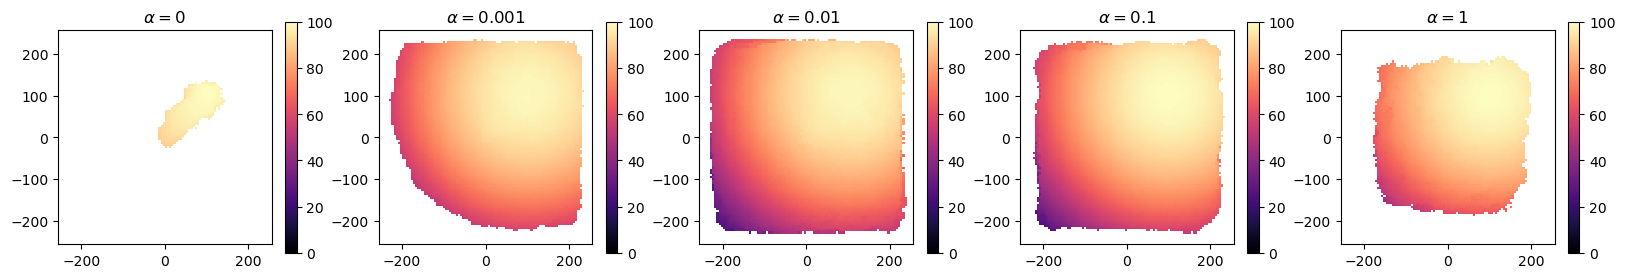

In [15]:
fig, axs = plt.subplots(1, len(learning_rates), figsize=(20, 3))
for i, (learning_rate, scheduler) in enumerate(zip(learning_rates, all_schedulers)):
    axs[i].set_title(f"$\\alpha = {learning_rate}$")
    grid_archive_heatmap(scheduler.result_archive,
                         ax=axs[i],
                         vmin=0,
                         vmax=100,
                         aspect=1.0)

These plots support our observations. We see that at $\alpha=0$, CMA-MAE heads straight to the optimum, while at $\alpha=1$, CMA-MAE spreads out but is unable to expand further. In intermediate values, CMA-MAE is able to balance optimization and exploration and thus fill the archive. Overall, these observations conform to our theoretical understanding of CMA-MAE.

## Conclusion

In this tutorial, we introduced CMA-MAE. We showed how it is implemented in pyribs, and we compared this implementation to that of CMA-ME. Then, we demonstrated CMA-MAE on the sphere linear projection benchmark, and we concluded by seeing how different settings of the learning rate $\alpha$ affected is performance. Overall, CMA-MAE has strong theoretical and empirical properties which enable it to excel at QD problems like this one. For these reasons, we recommend CMA-MAE over CMA-ME for most QD optimization problems.

_For implementations of a wide variety of algorithms on the sphere benchmark, take a look at our [sphere example](https://docs.pyribs.org/en/latest/examples/sphere.html)._

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_cma_mae,
  title   = {Upgrading CMA-ME to CMA-MAE on the Sphere Benchmark},
  author  = {David H. Lee and Bryon Tjanaka and Nivedit Reddy Balam and
             Matthew C. Fontaine and Stefanos Nikolaidis},
  journal = {pyribs.org},
  year    = {2023},
  url     = {https://docs.pyribs.org/en/stable/tutorials/cma_mae.html}
}
```